In [60]:
import os
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
from mda import anti_neighbors_vectorized
from plots import scatter_interpolate
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 16})
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
# from shapely.geometry import Point
# from scipy.stats import gaussian_kde

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

###### Production

In [19]:
# df = pd.read_pickle(r'T:\Projects\2016-2020-DHS-CRCoE\Tomas\Thesis\data\STORM\processed\STORM_NA_R3_In_pnt_v5.pkl')
df = pd.read_pickle(r'/home/tacuevas/Thesis/data/STORM/processed/STORM_NA_R4_In_pnt_v7.pkl')
df = df[df['rad_to_max_ws_at_min_distNC'] < df['rad_to_max_ws_at_min_distNC'].quantile(0.995)]
df = df[df['mean_curvature_roi'] < df['mean_curvature_roi'].quantile(0.995)]

df.index = df['tc_number']
dfr = df.drop(['year', 'yr_tc_number', 'tc_number', 'max_cat', 'time_step_at_min_press', 'time_step_at_min_distNC', 'lat_at_min_press', 'lon_at_min_press', 'min_press_at_min_press', 'max_ws_at_min_press',
             'rad_to_max_ws_at_min_press', 'forward_speed_at_min_press', 'distNC_at_min_press', 'trajectory_at_min_press', 'max_ws_at_min_distNC', 
               'trajectory_at_min_distNC', 'length', 'distNC_at_min_distNC', 'month'], axis = 1)

dfr.to_pickle(r'C:\Users\tacuevas\NCSU\Research\Thesis\STORM_NA_R4_In_pnt_v7_inpMDA.pkl')
dfr.index = range(len(dfr))
print(len(dfr.columns))
dfr.describe().T

12


,count,mean,std,min,25%,50%,75%,max
lat_at_min_distNC,9798.0,33.991784,1.818962,29.30,32.700000,34.300000,35.200000,40.100000
lon_at_min_distNC,9798.0,-75.825475,2.549226,-82.90,-77.600000,-75.600000,-73.900000,-70.800000
min_press_at_min_distNC,9798.0,982.032939,19.248129,903.50,970.800000,987.900000,997.400000,1010.400000
rad_to_max_ws_at_min_distNC,9798.0,50.910749,22.448376,9.26,37.040001,46.299999,60.498668,173.955712
forward_speed_at_min_distNC,9798.0,29.770965,12.082919,0.00,22.062189,29.581479,37.104259,112.175674
landfall,9798.0,0.717289,0.450340,0.00,0.000000,1.000000,1.000000,1.000000
trajectory_in_roi,9798.0,194.142806,141.780102,0.00,38.659808,288.434949,323.130102,355.601295
mean_trajectory_roi,9798.0,181.034249,142.377448,0.00,37.572742,167.711151,324.540184,360.000000
mean_curvature_roi,9798.0,0.187221,0.350838,0.00,0.043397,0.083747,0.168287,3.545342
duration,9798.0,121.474587,87.348998,24.00,51.000000,99.000000,171.000000,828.000000


In [20]:
index = [0 if 'trajectory' in x else 1 for x in dfr.columns]

In [21]:
cl = anti_neighbors_vectorized(dfr, 1_000, index)

100%|█████████████████████████████████████████| 999/999 [00:18<00:00, 54.51it/s]


In [22]:
dfr['tc_number'] = df.index

In [23]:
cl['tc_number'] = df.iloc[cl['index_cluster'], :].index

In [24]:
cl.to_pickle(r'/home/tacuevas/Thesis/data/STORM/processed/STORM_NA_R4_In_pnt_v7_MDAvec_12params_1000.pkl')

In [26]:
dct_cls = {'dfs':[], 'max_nclusters': [], 'min_nclusters':[], 'n':[]}
for n in range(250, 1050, 50):
    cl = anti_neighbors_vectorized(dfr.iloc[:, :-1], n, index)
    dct_cls['dfs'].append(cl)
    dct_cls['max_nclusters'].append(cl['npoints'].max())
    dct_cls['min_nclusters'].append(cl['npoints'].min())
    dct_cls['n'].append(n)

100%|█████████████████████████████████████████| 999/999 [00:17<00:00, 55.52it/s]


In [27]:
dfnclusters = pd.DataFrame()
for x, n in zip(dct_cls['dfs'], dct_cls['n']):
    vals = list(x['npoints'].values)
    if n < 1000:
        dummy = [np.nan]*(1000 - n)
        vals.extend(dummy)
    dfnclusters[n] = vals

In [62]:
plt.style.use('dark_background')

Text(0, 0.5, 'Number of cases per cluster [-]')

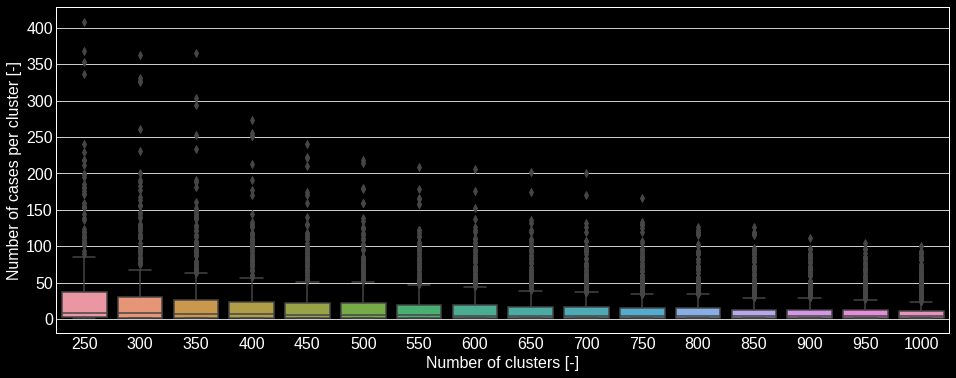

In [63]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.boxplot(data = dfnclusters, ax = ax)
ax.set_xlabel('Number of clusters [-]')
ax.set_ylabel('Number of cases per cluster [-]')

In [29]:
l = []
for x, n in zip(dct_cls['dfs'], dct_cls['n']):
    a = x[x['npoints'] > 200]
    l.append(a)
    print(f'Total num clusters: {len(x)} - n clusters with more than 200 points: {len(a)}')

Total num clusters: 250 - n clusters with more than 200 points: 9
Total num clusters: 300 - n clusters with more than 200 points: 6
Total num clusters: 350 - n clusters with more than 200 points: 5
Total num clusters: 400 - n clusters with more than 200 points: 5
Total num clusters: 450 - n clusters with more than 200 points: 4
Total num clusters: 500 - n clusters with more than 200 points: 2
Total num clusters: 550 - n clusters with more than 200 points: 1
Total num clusters: 600 - n clusters with more than 200 points: 1
Total num clusters: 650 - n clusters with more than 200 points: 1
Total num clusters: 700 - n clusters with more than 200 points: 0
Total num clusters: 750 - n clusters with more than 200 points: 0
Total num clusters: 800 - n clusters with more than 200 points: 0
Total num clusters: 850 - n clusters with more than 200 points: 0
Total num clusters: 900 - n clusters with more than 200 points: 0
Total num clusters: 950 - n clusters with more than 200 points: 0
Total num 

In [30]:
l = []
for x, n in zip(dct_cls['dfs'], dct_cls['n']):
    a = x['npoints'].max()
    b = x['npoints'].idxmax()
    print(f'Cluster with max points: {b} - {a} ({len(x)})')

Cluster with max points: 179 - 408 (250)
Cluster with max points: 62 - 363 (300)
Cluster with max points: 349 - 365 (350)
Cluster with max points: 62 - 273 (400)
Cluster with max points: 62 - 240 (450)
Cluster with max points: 179 - 218 (500)
Cluster with max points: 62 - 209 (550)
Cluster with max points: 62 - 206 (600)
Cluster with max points: 62 - 202 (650)
Cluster with max points: 62 - 200 (700)
Cluster with max points: 62 - 167 (750)
Cluster with max points: 147 - 127 (800)
Cluster with max points: 147 - 127 (850)
Cluster with max points: 62 - 111 (900)
Cluster with max points: 62 - 104 (950)
Cluster with max points: 62 - 101 (1000)


In [31]:
dfpnt = dct_cls['dfs'][-1].copy()

In [32]:
dfpnt.describe().T

,count,mean,std,min,25%,50%,75%,max
lat_at_min_distNC,1000.0,33.655600,2.156200,2.940000e+01,31.900000,33.800000,35.100000,40.100000
lon_at_min_distNC,1000.0,-75.655900,2.454639,-8.270000e+01,-77.200000,-75.600000,-73.800000,-70.900000
min_press_at_min_distNC,1000.0,982.560343,22.441501,9.058000e+02,969.325000,992.550000,999.712235,1010.000000
rad_to_max_ws_at_min_distNC,1000.0,58.328296,33.219246,9.260000e+00,34.991225,49.504688,74.080002,172.235995
forward_speed_at_min_distNC,1000.0,25.341045,17.864546,2.970937e+00,12.458277,22.113303,33.420303,112.175674
landfall,1000.0,0.581000,0.493642,0.000000e+00,0.000000,1.000000,1.000000,1.000000
trajectory_in_roi,1000.0,198.426075,130.233803,0.000000e+00,51.340192,270.000000,315.000000,354.805571
mean_trajectory_roi,1000.0,175.464806,130.286111,1.055327e-14,43.790145,163.265898,308.996845,359.671571
mean_curvature_roi,1000.0,0.604101,0.788873,0.000000e+00,0.080025,0.225760,0.810658,3.545342
duration,1000.0,168.045000,126.137947,2.400000e+01,63.000000,138.000000,243.000000,828.000000


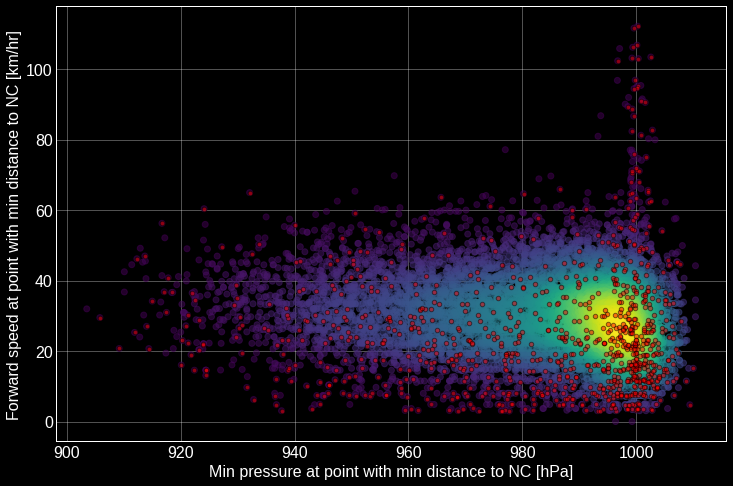

In [64]:
x = dfr.loc[:, 'min_press_at_min_distNC']
y = dfr.loc[:, 'forward_speed_at_min_distNC']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(x, y, cmap = cm, c = z, alpha = 0.5)
ax.scatter(cl.loc[:, 'min_press_at_min_distNC'], cl.loc[:, 'forward_speed_at_min_distNC'], c = 'r', alpha = 0.5, edgecolor = 'k', s = 20)
ax.set_xlabel('Min pressure at point with min distance to NC [hPa]')
ax.set_ylabel('Forward speed at point with min distance to NC [km/hr]')
ax.grid(True, alpha = 0.4)

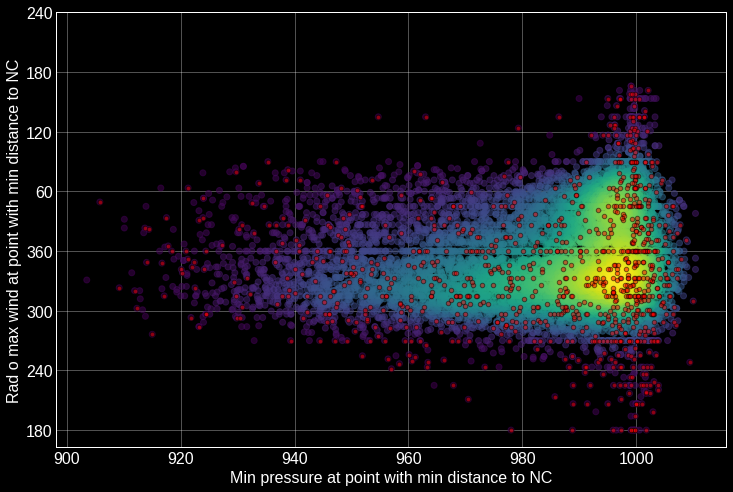

In [70]:
x = dfr.loc[:, 'min_press_at_min_distNC']
y = dfr.loc[:, 'trajectory_in_roi']
y = pd.Series([y + 360 if y < 180 else y for y in y])
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cm = plt.cm.get_cmap('viridis')

fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(x, y, cmap = cm, c = z, alpha = 0.5)
y = cl.loc[:, 'trajectory_in_roi']
y = pd.Series([y + 360 if y < 180 else y for y in y])
ax.scatter(cl.loc[:, 'min_press_at_min_distNC'], y, c = 'r', alpha = 0.5, edgecolor = 'k', s = 20)
ax.set_xlabel('Min pressure at point with min distance to NC')
ax.set_ylabel('Rad o max wind at point with min distance to NC')
ax.grid(True, alpha = 0.4)
ax.set_yticks(np.arange(180, 620, 60))
ax.set_yticklabels([int(x - 360) if x > 360 else int(x) for x in ax.get_yticks()]);